In [1]:
from time import perf_counter
from pathlib import Path

from src.convolutions import naive_2d_convolve, numpy_2d_convolve, sequential_convolve
from src.utils import gaussian_2d_kernel, run_and_time_function

import cv2
import numpy as np
import skimage
from skimage import data
from tifffile import imread
from matplotlib import pyplot as plt
from scipy.ndimage import convolve as scipy_convolve

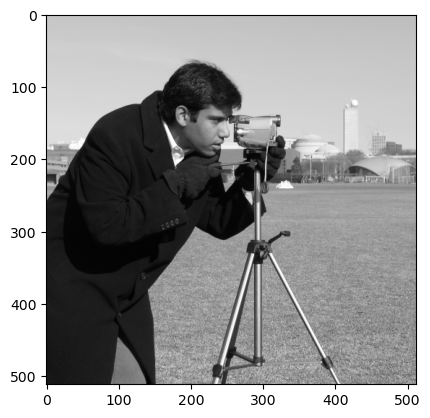

In [2]:
image = data.camera()
plt.imshow(image, cmap='gray')

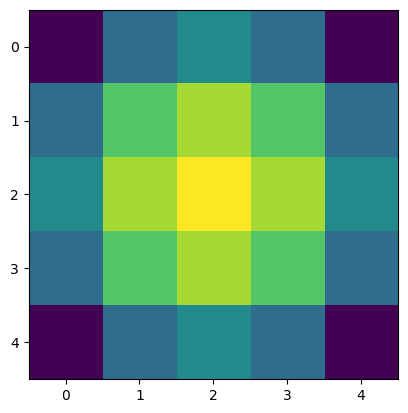

In [3]:
kernel = gaussian_2d_kernel(size=5, sigma=5.0)
plt.imshow(kernel) # Because it looks cool

In [4]:
naive_2d_time, naive_2d_convolution = run_and_time_function(naive_2d_convolve, image, kernel)
print(f'Naive convolution algorithm finished in {naive_2d_time} seconds')

numpy_2d_time, naive_2d_convolution = run_and_time_function(numpy_2d_convolve, image, kernel)
print(f'Numpy convolution algorithm finished in {numpy_2d_time} seconds')

Naive convolution algorithm finished in 2.22183654201217 seconds
Numpy convolution algorithm finished in 0.013148374971933663 seconds


That's roughly a 100x decrease in compute time. Even though my algorithm is purposefully convoluted (for the sake of learning) it is still far faster than any non-vectorized implementation.

In [5]:
scipy_2d_time, scipy_2d_convolution = run_and_time_function(scipy_convolve, image, kernel)
print(f'Scipy convolution algorithm finished in {scipy_2d_time} seconds')

Scipy convolution algorithm finished in 0.005194584024138749 seconds


Ok... well, it's not like I was really trying very hard to make mine blazingly fast... However, the difference in performance is far less than as seen in the numpy vs. naive version.

If you're not me and looking at this, I am prototyping separable convolutional filter below. The idea is that filters like Gaussian blur, are able to applied separately and sequentially across the different axes of the image

In [7]:
image_3d = data.cells3d()[:, 1, :, :]
image_3d = skimage.transform.rescale(image_3d, 2)
image_3d.shape

(120, 512, 512)

I've tested this (on one axis) using a matrix where one element is 1 and the rest are 0. When running just one pass of the convolve_1d function, this should result in a matrix where the elements surrounding that 1 (across just one dimension) equals the kernel. This is true for my implementation.

I've also tested it against Scipy's 1d convolution function (we can't test against a non-sequential convolution function because we pad at each step vs just once at the start) and ~9% of elements differ. I am unsure why :(

In [12]:
kernel = cv2.getGaussianKernel(20, 2.0).ravel()
separable_3d_time, separable_3d_convolution = run_and_time_function(sequential_convolve, image_3d, kernel)
separable_3d_time

0.7846680419752374

Looking good so far! Not bad huh... Let's compare it to SciPy's convolve function.

In [11]:
kernel_3d = np.einsum('i,j,k->ijk', kernel, kernel, kernel) # This still blows my mind! I <3 einsum!
scipy_3d_time, scipy_3d_convolution = run_and_time_function(scipy_convolve, image_3d.astype(np.float32), kernel_3d.astype(np.float32), mode='reflect')
scipy_3d_time

320.3438638750231

Wow! I beat an actual optimized C with Python (I know NumPy is also uses optimized C, but still)! Though, it's quite silly to use a generalized convolution function to apply a gaussian filter... Surely I will also beat Scipy's Gaussian Filter function!?

In [10]:
from scipy.ndimage import gaussian_filter
scipy_gaussian_time, scipy_gaussian_convolution = run_and_time_function(gaussian_filter, image_3d.astype(np.float32), 2.0, radius=10, mode='mirror')
scipy_gaussian_time

0.9380075839580968

Welp, it was nice while it lasted. Though I'm still very proud of the fact I was able to approach Scipy's implementation with Numpy! Actually, in another run I beat it?!

I'm actually quite confused by this development. My implementation in some instances performs better than Scipy's? From my understanding Scipy's is also implemented as sequential 1D filters, so it doesn't really make sense that it would be slower.

I've reached a roadblock in my attempt to figure out why, but I will ask online and hopefully someone has answers.